In [225]:
import argparse
import gym
from gym import wrappers
import numpy as np
import pdb
import os
import random
import time
import gc
import cv2
import pdb

import collections
import math
import typing
from typing import Dict, List, Optional

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [5]:
ENVS = {
    'breakout': 'Breakout-v0',
    'pong': 'Pong-v0',
}
STATE_PREPFN = {
    'breakout': lambda s: s[50:, :, :],
    'pong': lambda s: s[50:, :, :],
}

Env has:
* observation
* reward
* done
* info

Actions are:
['NOOP', 'FIRE', 'RIGHT', 'LEFT']

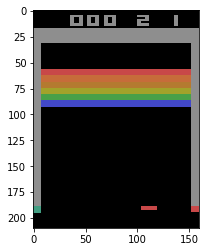

In [79]:
env = gym.make(ENVS['breakout'])

# set seed
# env.seed(args.seed)
# np.random.seed(args.seed)
# torch.manual_seed(args.seed)

# episode loop
for i in range(1):
    o = env.reset()
    render = plt.imshow(env.render(mode='rgb_array'))
    # rollout inner loop
    for t in range(100):
        # render code
        render.set_data(env.render(mode='rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
#         print(o.shape)
        a = env.action_space.sample()
#         print(a)
        o, r, done, _ = env.step(a)
#         print(r)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

## Helpers

In [87]:
MAXIMUM_FLOAT_VALUE = float('inf')

KnownBounds = collections.namedtuple('KnownBounds', ['min', 'max'])


class MinMaxStats(object):
    """A class that holds the min-max values of the tree."""

    def __init__(self, known_bounds: Optional[KnownBounds]):
        self.maximum = known_bounds.max if known_bounds else -MAXIMUM_FLOAT_VALUE
        self.minimum = known_bounds.min if known_bounds else MAXIMUM_FLOAT_VALUE

    def update(self, value: float):
        self.maximum = max(self.maximum, value)
        self.minimum = min(self.minimum, value)

    def normalize(self, value: float) -> float:
        if self.maximum > self.minimum:
            # We normalize only when we have set the maximum and minimum values.
            return (value - self.minimum) / (self.maximum - self.minimum)
        return value

### MuZero Config Params

In [88]:
class MuZeroConfig(object):

    def __init__(self,
                action_space_size: int,
                max_moves: int,
                discount: float,
                dirichlet_alpha: float,
                num_simulations: int,
                batch_size: int,
                td_steps: int,
                num_actors: int,
                lr_init: float,
                lr_decay_steps: float,
                visit_softmax_temperature_fn,
                known_bounds: Optional[KnownBounds] = None):
        ### Self-Play
        self.action_space_size = action_space_size
        self.num_actors = num_actors

        self.visit_softmax_temperature_fn = visit_softmax_temperature_fn
        self.max_moves = max_moves
        self.num_simulations = num_simulations
        self.discount = discount

        # Root prior exploration noise.
        self.root_dirichlet_alpha = dirichlet_alpha
        self.root_exploration_fraction = 0.25

        # UCB formula
        self.pb_c_base = 19652
        self.pb_c_init = 1.25

        # If we already have some information about which values occur in the
        # environment, we can use them to initialize the rescaling.
        # This is not strictly necessary, but establishes identical behaviour to
        # AlphaZero in board games.
        self.known_bounds = known_bounds

        ### Training
        self.training_steps = int(1000e3)
        self.checkpoint_interval = int(1e3)
        self.window_size = int(1e6)
        self.batch_size = batch_size
        self.num_unroll_steps = 5
        self.td_steps = td_steps

        self.weight_decay = 1e-4
        self.momentum = 0.9

        # Exponential learning rate schedule
        self.lr_init = lr_init
        self.lr_decay_rate = 0.1
        self.lr_decay_steps = lr_decay_steps

    def new_game(self):
        return Game(self.action_space_size, self.discount)
    
def make_atari_config() -> MuZeroConfig:

    def visit_softmax_temperature(num_moves, training_steps):
        if training_steps < 500e3:
            return 1.0
        elif training_steps < 750e3:
            return 0.5
        else:
            return 0.25

    return MuZeroConfig(
        action_space_size=4,
        max_moves=27000,  # Half an hour at action repeat 4.
        discount=0.997,
        dirichlet_alpha=0.25,
        num_simulations=50,
        batch_size=1024,
        td_steps=10,
        num_actors=350,
        lr_init=0.05,
        lr_decay_steps=350e3,
        visit_softmax_temperature_fn=visit_softmax_temperature)

In [297]:
class Action(object):

    def __init__(self, index: int):
        self.index = index

    def __hash__(self):
        return self.index

    def __eq__(self, other):
        return self.index == other.index

    def __gt__(self, other):
        return self.index > other.index
    
    def __str__(self):
        return f"Action({self.index})"

In [91]:
class Node(object):

    def __init__(self, prior: float):
        self.visit_count = 0
        self.to_play = -1
        self.prior = prior
        self.value_sum = 0
        self.children = {}
        self.hidden_state = None
        self.reward = 0

    def expanded(self) -> bool:
        return len(self.children) > 0

    def value(self) -> float:
        if self.visit_count == 0:
            return 0
        return self.value_sum / self.visit_count

In [118]:
class ActionHistory(object):
    """Simple history container used inside the search.

    Only used to keep track of the actions executed.
    """

    def __init__(self, history: List[Action], action_space_size: int):
        self.history = list(history)
        self.action_space_size = action_space_size

    def clone(self):
        return ActionHistory(self.history, self.action_space_size)

    def add_action(self, action: Action):
        self.history.append(action)

    def last_action(self) -> Action:
        return self.history[-1]

    def action_space(self) -> List[Action]:
        return [Action(i) for i in range(self.action_space_size)]

In [242]:
class Environment(object):
    """The environment MuZero is interacting with."""
    def __init__(self):
        self.env = gym.make(ENVS['breakout'])
        self.obs_history = [self.prepro(self.env.reset())]
        self.done = False
        
    def step(self, action):
        obs, reward, self.done, info = self.env.step(action)
        self.obs_history.apppend(self.prepro(obs))
        return reward
    
    def terminal(self):
        return self.done
    
    def legal_actions(self):
        """Env specific rules for legality of moves
        TODO: if at wall don't allow movement into the wall"""
        return [Action(a) for a in range(self.env.action_space.n)]
    
    def prepro(self, obs, size=(80,80)):
        """Crop, resize, B&W"""
        p_obs = obs[25:195,:,0] / 255 # crop and normalise to [0,1]
        return cv2.resize(p_obs, size, interpolation=cv2.INTER_NEAREST) # resize
                            
    def get_obs(self, start:int, end:int=None):
        return self.obs_history[max(start,0):end]

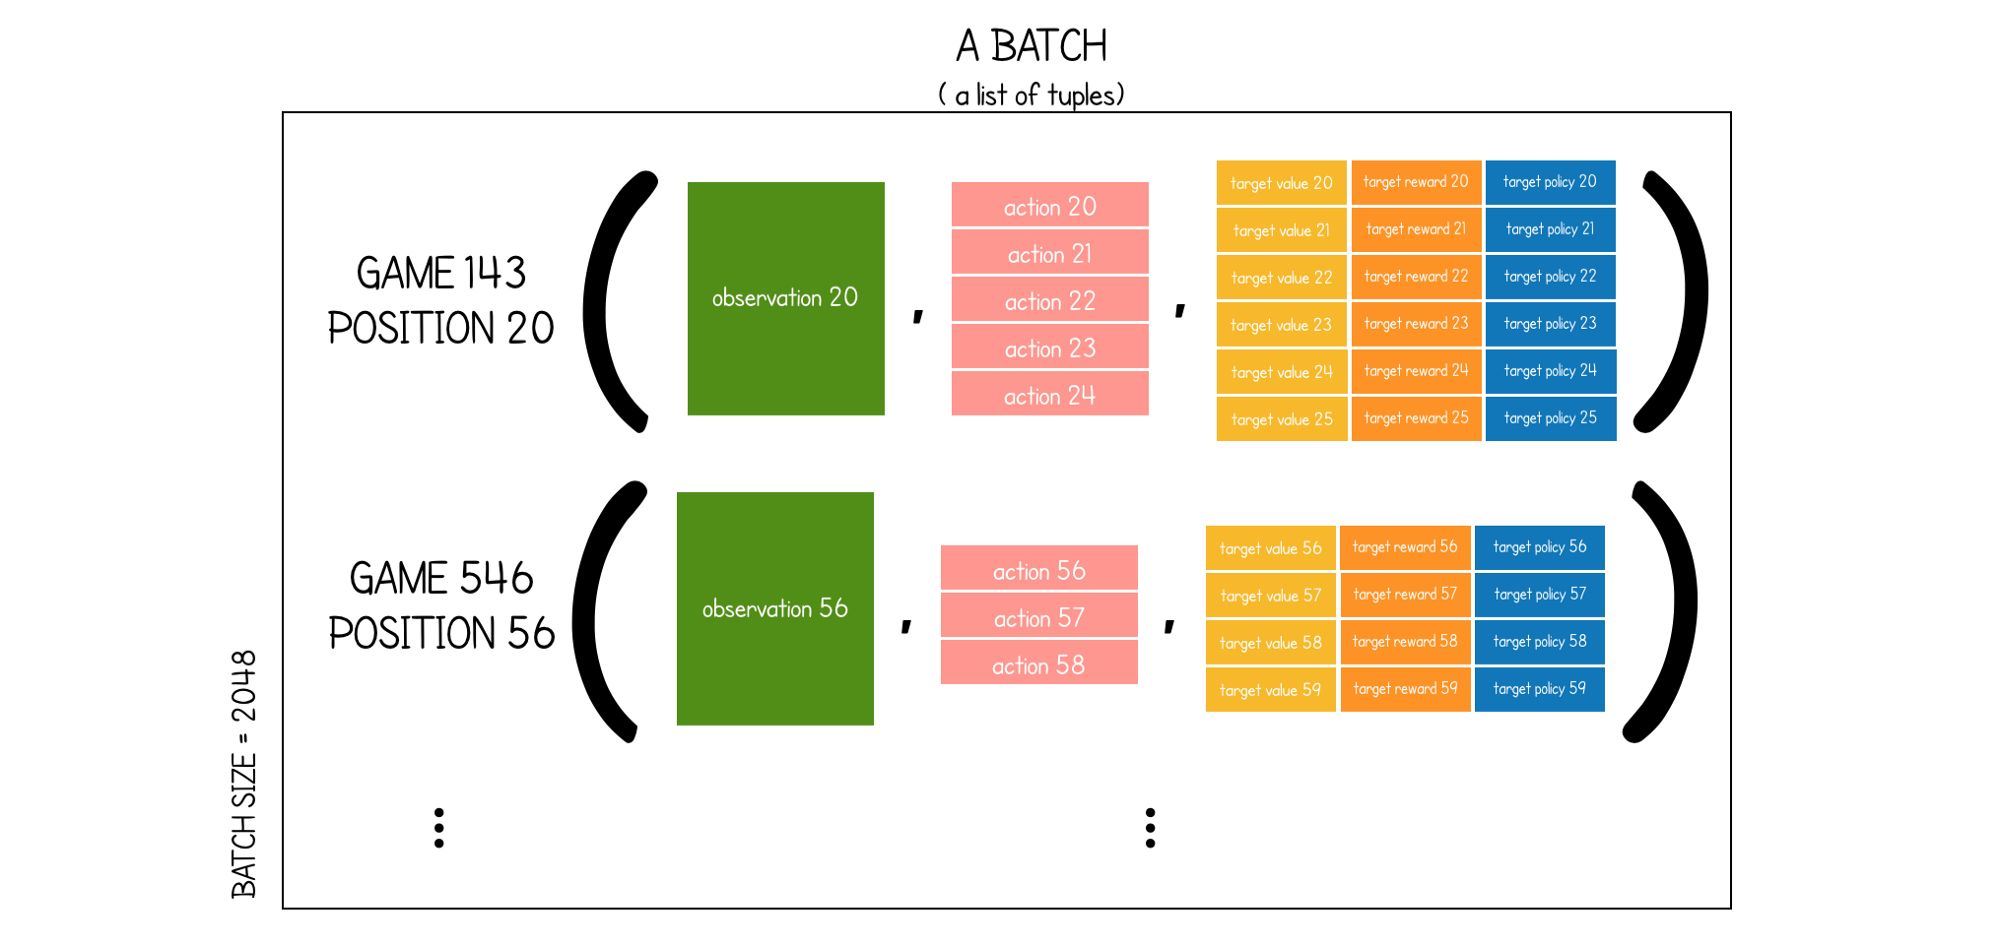

Refresher on TD Learning, which is what is used to estimate the value targets.

If we were to calculate value function without estimation we would have to wait until the final reward updates could be propagated:
$$V(s_t) = V(s_t) + \alpha[R_t-V(s_t)]$$
where $s_t$ is state visited at time $t$, $R_t$ is total reward after time $t$ and $\alpha$ is the LR.

However for TD methods, an estimate of the final reward is calculated at each state and (s,a) value updated for every step of the way. We are essentially doing a finite step lookahead and updating based on that estimate. TD method is called a "bootstrapping" method, becuase the value is updated partly using an existing estimate and not a final reward.
$$V(s_t) = V(s_t) + \alpha[r_{t+1}+\gamma V(s_{t+1})-V(s_t)]$$
and in our case we formulate this as an N step bootstrap:
$$z_t=u_{t+1} + \gamma u_{t+2} + ... + \gamma^{n-1} u_{t+n} + \gamma^n \nu_{t+n}$$

In [291]:
class Game(object):
    """A single episode of interaction with the environment. (One trajectory)"""
    def __init__(self, action_space_size: int, discount: float):
        self.env = Environment()
        self.history = [] # actual actions a
        self.rewards = [] # observed rewards u
        self.child_visits = [] # search tree action distributions pi
        self.root_values = [] # values ν
        self.action_space_size = action_space_size
        self.gamma = discount
    
    def terminal(self) -> bool:
        return self.env.terminal()
    
    def legal_actions(self) -> List[Action]:
        return self.env.legal_actions()
    
    def apply(self, action: Action):
        reward = self.environment.step(action)
        self.rewards.append(reward)
        self.history.append(action)
        
    def store_search_statistics(self, root: Node):
        """Stores the MCTS search value of node and search policy (visits ratio of children)"""
        sum_visits = sum(child.visit_count for child in root.children_values())
        action_space = (Action(index) for index in range(self.action_space_size))
        # search policy π = [0.1,0.5,0.4] probability over children
        self.child_visits.append([
            root.children[a].visit_count / sum_visits if a in root.children else 0
            for a in action_space
        ])
        # search value ν
        self.root_values.append(root.value())
    
    def make_image(self, t: int, feat_history_len:int = 32):
        """Observation at chosen position w/ history"""
        # Game specific feature planes
        # For Atari we have the 32 most recent RGB frames at resolution 96x96
        # Instead I use 80x80x1 B&W
        frames = self.env.get_obs(t-feat_history_len+1, t+2) # We want 32 frames up to and including t
        # Cast to tensor and add dummy batch dim
        frame_tensor = torch.Tensor(frames).unsqueeze(0)
        # If we're missing a channel dim add one
        if len(frame_tensor)==3:
            frame_tensor = frame_tensor.unsqueeze(1)
        # Pad out sequences with insufficient history
        padding_size = feat_history_len-frame_tensor.shape[0]
        padded_frames = F.pad(input=frame_tensor, pad=(0, 0, 0, 0, padding_size, 0), mode='constant', value=0)
        return padded_frames
    
    def make_target(self, t: int, K: int, td: int):
        """
        (value,reward,policy) target for each unroll step t to t+K
        This is taken from actuals results of the game (to be stored in replay buffer)
        Uses TD learning to calculate value target via n step bootstrap, see above
        """
        # The value target is the discounted root value of the search tree N steps
        # into the future, plus the discounted sum of all rewards until then.
        # Returns target tuple (value, reward, policy) i.e. (z,u,pi)
        # K=5
        targets = []
        for current_index in range(t, t + K + 1):
            ## Value Target z_{t+K} ##
            
            bootstrap_index = current_index + td 
            # If our TD lookahead is still before the end of the game, the update with that 
            # future game state value estimate ν_{t+N}
            if bootstrap_index < len(self.root_values):
                # γ^N*ν_{t+N}
                value =  self.root_values[bootstrap_index] * self.gamma**td
            else:
                value = 0
            
            # Rest of the TD value estimate from observed rewards: u_{t+1} + ... + γ^{N-1} u_{t+n}
            for i, reward in enumerate(self.rewards[current_index:bootstrap_index]):
                value += reward * self.gamma**i
                
            ## Reward u_{t+K} and Action π_{t+K} Targets ##
            
            # For simplicity the network always predicts the most recently received
            # reward, even for the initial representation network where we already
            # know this reward.
            if current_index > 0 and current_index <= len(self.rewards):
                last_reward = self.rewards[current_index - 1]
            else:
                last_reward = 0
            
            if current_index < len(self.root_values):
                targets.append((value, last_reward, self.child_visits[current_index]))
            else:
                # States past the end are treated as absorbing states
                targets.append((0, last_reward, []))
        return targets 
    
    def action_history(self) -> ActionHistory:
        return ActionHistory(self.history, self.action_space_size)

In [145]:
class ReplayBuffer(object):
    """Stores the target tuples to sample from later during training"""
    def __init__(self, config: MuZeroConfig):
        self.window_size = config.window_size
        self.batch_size = config.batch_size
        self.buffer = []

    def save_game(self, game):
        # Pop off oldest replays to make space for new ones
        if len(self.buffer) > self.window_size:
            self.buffer.pop(0)
        self.buffer.append(game)

    def sample_batch(self, K: int, td: int):
        """
        Inputs
            K: num unroll steps
            td: num TD steps
        Outputs
            (observation, next K actions, target tuple)
        """
        games = [self.sample_game() for _ in range(self.batch_size)]
        game_pos = [(g, self.sample_position(g)) for g in games]
        return [(g.make_image(i), g.history[i:i + K],
                 g.make_target(i, num_unroll_steps, td))
                for (g, i) in game_pos]

    def sample_game(self) -> Game:
        # TODO: figure out sampling regime
        # Sample game from buffer either uniformly or according to some priority e.g. importance sampling.
        game_ix = random.randint(0,len(buffer)-1) # random uniform
        return self.buffer[game_ix]

    def sample_position(self, game) -> int:
        # Sample position from game either uniformly or according to some priority.
        pos_ix = random.randint(0,len(game.root_values)-1) # random uniform
        return pos_ix

## NN Networks

#### 1. Prediction Network (F)
The prediction function pk, vk = fθ(sk) uses the same architecture as AlphaZero: one or two convolutional layers that preserve the resolution but reduce the number of planes, followed by a fully connected layer to the size of the output.

#### 2. Dynamics Network (G)
Both the representation and dynamics function use the same architecture as AlphaZero, but with 16 instead of 20 residual blocks. We use 3x3 kernels and 256 hidden planes for each convolution. 

For the dynamics function (which always operates at the downsampled resolution of 6x6), the action is first encoded as an image, then stacked with the hidden state of the previous step along the plane dimension

#### 3. Representation Network (H)
For Atari, where observations have large spatial resolution, the representation function starts with a sequence
of convolutions with stride 2 to reduce the spatial resolution. Specifically, starting with an input observation of resolution 96x96 and 128 planes (32 history frames of 3 color channels each, concatenated with the corresponding 32 actions broadcast to planes), we downsample as follows:
* 1 convolution with stride 2 and 128 output planes, output resolution 48x48. 
* 2 residual blocks with 128 planes 
* 1 convolution with stride 2 and 256 output planes, output resolution 24x24. 
* 3 residual blocks with 256 planes. 
* Average pooling with stride 2, output resolution 12x12. 
* 3 residual blocks with 256 planes. 
* Average pooling with stride 2, output resolution 6x6.
The kernel size is 3x3 for all operations.

In [219]:
# TODO: Get rid of hardcoded values
class ResBlock(nn.Module):
    def __init__(self, inplanes=128, planes=128, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = F.relu(out)
        return out
    
class ConvBlock(nn.Module):
    def __init__(self, inplanes=128, planes=128, stride=1, downsample=None):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        return out

class ReprNet(nn.Module):
    """Representation Function h(o)->s_0"""
    def __init__(self, in_channels=32, nf=128):
        super(ReprNet, self).__init__()
        self.conv1 = ConvBlock(in_channels,nf,stride=2) # 40
        self.res1 = ResBlock(nf, nf)
        self.conv2 = ConvBlock(nf,nf,stride=2) # 20
        self.res2 = ResBlock(nf, nf)
        self.conv3 = ConvBlock(nf,nf,stride=2) # 10
        self.res3 = ResBlock(nf, nf)
        self.conv4 = ConvBlock(nf,nf,stride=2) # 5
        self.res4 = ResBlock(nf, nf)

    def forward(self, x):
        x = self.conv1(x)
#         x = self.res1(x)
        x = self.conv2(x)
#         x = self.res2(x)
        x = self.conv3(x)
#         x = self.res3(x)
        x = self.conv4(x)
#         x = self.res4(x)
        return x # s: 128x5x5

class DynaNet(nn.Module):
    """Dynamics Function g(s,a)->(s',r)"""
    def __init__(self, in_height=5, in_width=5, in_channels=128+1, nf=128):
        super(DynaNet, self).__init__()
        self.in_height = in_height
        self.in_width = in_width
        self.nf = nf
        
        self.conv1 = ConvBlock(in_channels,nf,stride=1)
        self.res1 = ResBlock(nf, nf)
        self.conv2 = ConvBlock(nf,nf,stride=1) 
        self.res2 = ResBlock(nf, nf)
        self.conv3 = ConvBlock(nf,nf,stride=1) 
        self.res3 = ResBlock(nf, nf)
        self.conv4 = ConvBlock(nf,nf,stride=1) 
        self.res4 = ResBlock(nf, nf)
        self.reward_head = nn.Linear(nf*in_height*in_width, 1)

    def forward(self, x):
        x = self.conv1(x)
#         x = self.res1(x)
        x = self.conv2(x)
#         x = self.res2(x)
        x = self.conv3(x)
#         x = self.res3(x)
        x = self.conv4(x)
#         x = self.res4(x)
        r = self.reward_head(x.view(-1,self.nf*self.in_height*self.in_width))
        return x, r # s': 128x5x5, r=1

class PredNet(nn.Module):
    """Policy-Value Prediction Function f(s)->(p,v)"""
    def __init__(self, in_height=5, in_width=5, in_channels=128, num_actions=4): #6x6 state 
        super(PredNet, self).__init__()
        self.in_height = in_height
        self.in_width = in_width
        
        # common layers
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        # action policy layers
        self.act_head = nn.Linear(32*in_height*in_width, num_actions)
        # state value layers
        self.val_head = nn.Linear(32*in_height*in_width, 1)

    def forward(self, s):
        # common layers
        x = F.relu(self.conv1(s))
        x = F.relu(self.conv2(x))
        # action policy layers
        x_act = x.view(-1, 32*self.in_height*self.in_width)
        x_act = F.log_softmax(self.act_head(x_act), dim=1)
        # state value layers
        x_val = x.view(-1, 32*self.in_height*self.in_width)
        x_val = F.tanh(self.val_head(x_val)) # tanh? 
        return x_act, x_val

In [216]:
# Input: (32,80,80) - 80x80 game in B&W with 32 length obs history
# Output: (128,5,5) - s0
summary(ReprNet(), input_size=(32,80,80)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 40, 40]          36,864
       BatchNorm2d-2          [-1, 128, 40, 40]             256
         ConvBlock-3          [-1, 128, 40, 40]               0
            Conv2d-4          [-1, 128, 20, 20]         147,456
       BatchNorm2d-5          [-1, 128, 20, 20]             256
         ConvBlock-6          [-1, 128, 20, 20]               0
            Conv2d-7          [-1, 128, 10, 10]         147,456
       BatchNorm2d-8          [-1, 128, 10, 10]             256
         ConvBlock-9          [-1, 128, 10, 10]               0
           Conv2d-10            [-1, 128, 5, 5]         147,456
      BatchNorm2d-11            [-1, 128, 5, 5]             256
        ConvBlock-12            [-1, 128, 5, 5]               0
Total params: 480,256
Trainable params: 480,256
Non-trainable params: 0
-------------------------------

In [217]:
# Input: (129,5,5) - 5x5 internal state with nf channels +1 action dim
# Output: (128,5,5), (1,) - s', r
summary(DynaNet(), input_size=(128+1,5,5)) # 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 128, 5, 5]         148,608
       BatchNorm2d-2            [-1, 128, 5, 5]             256
         ConvBlock-3            [-1, 128, 5, 5]               0
            Conv2d-4            [-1, 128, 5, 5]         147,456
       BatchNorm2d-5            [-1, 128, 5, 5]             256
         ConvBlock-6            [-1, 128, 5, 5]               0
            Conv2d-7            [-1, 128, 5, 5]         147,456
       BatchNorm2d-8            [-1, 128, 5, 5]             256
         ConvBlock-9            [-1, 128, 5, 5]               0
           Conv2d-10            [-1, 128, 5, 5]         147,456
      BatchNorm2d-11            [-1, 128, 5, 5]             256
        ConvBlock-12            [-1, 128, 5, 5]               0
           Linear-13                    [-1, 1]           3,201
Total params: 595,201
Trainable params:

In [218]:
# Input: (128,5,5) - 5x5 internal state with nf channels
# Output: (4,), (1,) - p, v
summary(PredNet(), input_size=(128,5,5))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 5, 5]          73,792
            Conv2d-2             [-1, 32, 5, 5]          18,464
            Linear-3                    [-1, 4]           3,204
            Linear-4                    [-1, 1]             801
Total params: 96,261
Trainable params: 96,261
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 0.37
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


In [146]:
class NetworkOutput(typing.NamedTuple):
    value: float
    reward: float
    policy_logits: Dict[Action, float]
    hidden_state: List[float] # not sure about this one lol

In [285]:
class Network(object):
    """TODO: Implement in Pytorch/TF"""
    def __init__(self, h_in=5, w_in=5, c_in=32, nf=128, n_acts=4):
        # Initialise a uniform network - should I init these networks explicitly?
        self.f = PredNet(h_in, w_in, nf, n_acts)
        self.g = DynaNet(h_in, w_in, nf+1, nf)
        self.h = ReprNet(c_in, nf)
        self.steps = 0
        
    def initial_inference(self, obs) -> NetworkOutput:
        # representation + prediction function
        # input: 32x80x80 observation
        state = self.h(obs)
        policy_logits, value = self.f(state)
        policy = {Action(i):p for i,p in enumerate(policy_logits[0].tolist())}
        return NetworkOutput(value[0], 0, policy, state)

    def recurrent_inference(self, hidden_state, action) -> NetworkOutput:
        # dynamics + prediction function
        return NetworkOutput(0, 0, {}, [])

    def get_weights(self):
        # Returns the weights of this network.
        self.steps += 1 # probably not ideal
        return [self.f.parameters(), self.g.parameters(), self.h.parameters()]

    def training_steps(self) -> int:
        # How many steps / batches the network has been trained for.
        return self.steps

In [286]:
class SharedStorage(object):

    def __init__(self):
        self._networks = {}

    def latest_network(self) -> Network:
        if self._networks:
            return self._networks[max(self._networks.keys())]
        else:
            # policy -> uniform, value -> 0, reward -> 0
            return make_uniform_network()

    def save_network(self, step: int, network: Network):
        self._networks[step] = network

def make_uniform_network():
    return Network()

# 1. Self-play

In [287]:
# Each self-play job is independent of all others; it takes the latest network
# snapshot, produces a game and makes it available to the training job by
# writing it to a shared replay buffer.
def run_selfplay(config: MuZeroConfig, storage: SharedStorage,
                 replay_buffer: ReplayBuffer):
    """TODO: Multithread this"""
    while True:
        network = storage.latest_network()
        game = play_game(config, network)
        replay_buffer.save_game(game)

### Run 1 Game/Trajectory

In [121]:
# Each game is produced by starting at the initial board position, then
# repeatedly executing a Monte Carlo Tree Search to generate moves until the end
# of the game is reached.
def play_game(config: MuZeroConfig, network: Network) -> Game:
    game = config.new_game()

    while not game.terminal() and len(game.history) < config.max_moves:
        # At the root of the search tree we use the representation function h to
        # obtain a hidden state given the current observation.
        root = Node(0)
        current_observation = game.make_image(-1) # 80x80x1
        expand_node(root, game.legal_actions(),
                    network.initial_inference(current_observation))
        add_exploration_noise(config, root)

        # We then run a Monte Carlo Tree Search using only action sequences and the
        # model learned by the network.
        run_mcts(config, root, game.action_history(), network)
        action = select_action(config, len(game.history), root, network)
        game.apply(action)
        game.store_search_statistics(root)
    return game

#### Exploration Noise

In [289]:
# At the start of each search, we add dirichlet noise to the prior of the root
# to encourage the search to explore new actions.
def add_exploration_noise(config: MuZeroConfig, node: Node):
    actions = list(node.children.keys())
    noise = np.random.dirichlet([config.root_dirichlet_alpha] * len(actions))
    frac = config.root_exploration_fraction
    for a, n in zip(actions, noise):
        node.children[a].prior = node.children[a].prior * (1 - frac) + n * frac

### Softmax search policy $\pi$

In [123]:
def select_action(config: MuZeroConfig, num_moves: int, node: Node,
                  network: Network):
    """Search policy: softmax probability over actions dictated by visited counts"""
    # Visit counts of chilren nodes - policy proportional to counts
    visit_counts = [
        (child.visit_count, action) for action, child in node.children.items()
    ]
    # Get softmax temp
    t = config.visit_softmax_temperature_fn(
        num_moves=num_moves, training_steps=network.training_steps())
    _, action = softmax_sample(visit_counts, t)
    return action

def softmax_sample(distribution, T: float):
    return nn.Softmax(dim=1)(distribution/T)

### MCTS

In [122]:
# Core Monte Carlo Tree Search algorithm.
# To decide on an action, we run N simulations, always starting at the root of
# the search tree and traversing the tree according to the UCB formula until we
# reach a leaf node.
def run_mcts(config: MuZeroConfig, root: Node, action_history: ActionHistory,
             network: Network):
    """TODO: Multithread"""
    min_max_stats = MinMaxStats(config.known_bounds)

    for _ in range(config.num_simulations):
        history = action_history.clone()
        node = root
        search_path = [node]

        # Traverse tree, expanding by highest UCB until leaf reached
        while node.expanded():
            action, node = select_child(config, node, min_max_stats) # UCB selection
            history.add_action(action)
            search_path.append(node)

        # Inside the search tree we use the dynamics function to obtain the next
        # hidden state given an action and the previous hidden state.
        parent = search_path[-2] # parent of leaf
        # Dynamics: g(s_{k-1},a_k) = r_k, s_k
        # Predictions: f(s_k) = v_k, p_k
        # -> (v,r,p,s)
        network_output = network.recurrent_inference(parent.hidden_state,
                                                     history.last_action())
        # expand node using v,r,p predictions from NN
        expand_node(node, history.action_space(), network_output)

        # back up values to the root node
        backpropagate(search_path, network_output.value, config.discount, 
                      min_max_stats)

#### i. Selection: UCB Child Selection
We select the child node/state based on the action that maximises over an upper confidence bound (UCB):
$$a^{k}=\arg \max _{a}\left[Q(s, a)+P(s, a) \cdot \frac{\sqrt{\sum_{b} N(s, b)}}{1+N(s, a)}\left(c_{1}+\log \left(\frac{\sum_{b} N(s, b)+c_{2}+1}{c_{2}}\right)\right)\right]$$
To clarify: $\sum_{b} N(s, b)$ is just the sum of counts over all child nodes, i.e. the count of the parent node.

"The constants c1 and c2 are used to control the influence of the prior P(s, a) relative to the value Q(s, a) as
nodes are visited more often. In our experiments, $c_1$ = 1.25 and $c_2$ = 19652" - (pg. 12)

In [128]:
# Select the child with the highest UCB score.
def select_child(config: MuZeroConfig, node: Node,
                 min_max_stats: MinMaxStats):
    _, action, child = max(
        (ucb_score(config, node, child, min_max_stats), action,
         child) for action, child in node.children.items())
    return action, child

# The score for a node is based on its value, plus an exploration bonus based on
# the prior.
def ucb_score(config: MuZeroConfig, parent: Node, child: Node,
              min_max_stats: MinMaxStats) -> float:
    pb_c = math.log((parent.visit_count + config.pb_c_base + 1) /
                  config.pb_c_base) + config.pb_c_init
    pb_c *= math.sqrt(parent.visit_count) / (child.visit_count + 1)

    # P(s,a)*pb_c
    prior_score = pb_c * child.prior
    # Q(s,a)
    if child.visit_count > 0:
        value_score = child.reward + config.discount * min_max_stats.normalize(
            child.value())
    else:
        value_score = 0
    return prior_score + value_score

#### ii. Expansion: Leaf Node Expansion + Prediction

In [129]:
# We expand a node using the value, reward and policy prediction obtained from
# the neural network.
def expand_node(node: Node, actions: List[Action], network_output: NetworkOutput):
    """Updates predictions for state s, reward r and policy p for node based on NN outputs"""
    # Update leaf with predictions from parent
    node.hidden_state = network_output.hidden_state # s
    node.reward = network_output.reward # r
    policy = {a: math.exp(network_output.policy_logits[a]) for a in actions} # unnormalised probabilities
    policy_sum = sum(policy.values()) 
    for action, p in policy.items():
        node.children[action] = Node(p / policy_sum) # p

#### iii. Backup: Search Tree Update/Backprop
$$G^{k}=\sum_{\tau=0}^{l-1-k} \gamma^{\tau} r_{k+1+\tau}+\gamma^{l-k} v^{l}$$
For $k = l...1$, we update the statistics for each edge $\left(s^{k-1}, a^{k}\right)$ in the simulation
$$Q\left(s^{k-1}, a^{k}\right):=\frac{N\left(s^{k-1}, a^{k}\right) \cdot Q\left(s^{k-1}, a^{k}\right)+G^{k}}{N\left(s^{k-1}, a^{k}\right)+1}$$
$$N\left(s^{k-1}, a^{k}\right):=N\left(s^{k-1}, a^{k}\right)+1$$
Q value estimates are normalised so that we can combine value estimates with probabilities via pUCT rule (above)
$$\bar{Q}\left(s^{k-1}, a^{k}\right)=\frac{Q\left(s^{k-1}, a^{k}\right)-\min _{s, a \in \operatorname{Tree}} Q(s, a)}{\max _{s, a \in \operatorname{Tree}} Q(s, a)-\min _{s, a \in \operatorname{Tree}} Q(s, a)}$$

In [132]:
# At the end of a simulation, we propagate the evaluation all the way up the
# tree to the root.
def backpropagate(search_path: List[Node], value: float,
                  discount: float, min_max_stats: MinMaxStats):
    # Traverse back up UCB search path
    for node in reversed(search_path):
        node.value_sum += value # if node.to_play == to_play else -value
        node.visit_count += 1
        min_max_stats.update(node.value())

        value = node.reward + discount * value

### Testing

In [309]:
config = make_atari_config()
ss = SharedStorage()
rbuf = ReplayBuffer(config)

run_selfplay(config, ss, rbuf)

/Users/tfrizza/Documents/robotic_learning/rl_venv/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


KeyError: <__main__.Action object at 0x7fc4b8c729d0>

In [310]:
pdb.pm()

> <ipython-input-129-a96cf79024ea>(8)<dictcomp>()
-> policy = {a: math.exp(network_output.policy_logits[a]) for a in actions} # unnormalised probabilities


(Pdb)  u


> <ipython-input-129-a96cf79024ea>(8)expand_node()
-> policy = {a: math.exp(network_output.policy_logits[a]) for a in actions} # unnormalised probabilities


(Pdb)  p actions


[<__main__.Action object at 0x7fc4b8c729d0>, <__main__.Action object at 0x7fc4b8c72510>, <__main__.Action object at 0x7fc4b8c72b90>, <__main__.Action object at 0x7fc4b8c72250>]


(Pdb)  p [str(a) for a in actions]


['Action(0)', 'Action(1)', 'Action(2)', 'Action(3)']


(Pdb)  network_policy


*** NameError: name 'network_policy' is not defined


(Pdb)  network_output.policy_logits


{}


(Pdb)  q


#### Status
Up to implementing recurrent_inference()